In [52]:
import pandas as pd

df = pd.read_csv("PDA.csv")

# See what’s inside first
print(df.shape)
print(df.columns.tolist())

# Look at rows
df.head(8)

(170317, 21)
['YEAR', 'AGECAT', 'SEX', 'MARRIED', 'EDUCAT', 'EMPLOY18', 'CTYMETRO', 'HEALTH', 'MENTHLTH', 'PRLMISEVR', 'PRLMISAB', 'PRLANY', 'HEROINEVR', 'HEROINUSE', 'TRQLZRS', 'SEDATVS', 'COCAINE', 'AMPHETMN', 'HALUCNG', 'TRTMENT', 'MHTRTMT']


,YEAR,AGECAT,SEX,MARRIED,EDUCAT,EMPLOY18,CTYMETRO,HEALTH,MENTHLTH,PRLMISEVR,...,PRLANY,HEROINEVR,HEROINUSE,TRQLZRS,SEDATVS,COCAINE,AMPHETMN,HALUCNG,TRTMENT,MHTRTMT
0,15,3,1,0,2,2,0,3,4,1,...,10,1,5,5,0,5,2,2,6,0
1,15,3,0,0,3,1,0,6,7,1,...,10,1,5,5,0,4,3,5,5,0
2,15,2,0,0,3,0,0,4,2,1,...,9,1,5,5,0,4,2,3,7,2
3,15,1,0,0,1,0,0,5,0,1,...,9,1,5,5,0,3,2,2,0,0
4,15,5,0,0,3,0,0,5,2,1,...,9,1,5,5,3,2,2,2,7,0
5,15,3,0,0,2,2,0,5,3,1,...,8,1,5,5,0,2,2,4,0,0
6,15,3,0,0,2,0,0,1,0,1,...,8,1,5,4,0,5,4,3,0,0
7,15,3,0,0,5,0,0,3,0,1,...,8,1,5,0,0,3,1,0,0,0


In [16]:
from dataclasses import dataclass
import numpy as np

@dataclass
class Agent:
    id: int
    age: int
    sex: int
    mental_health: float
    previous_misuse: int
    other_drug_use: float
    p_base: float
    using: bool = False

In [18]:
MISUSE_COL    = "PRLANY"
AGE_COL       = "AGECAT"
SEX_COL       = "SEX"
MENTAL_COL    = "MENTHLTH"

HEROIN_COL    = "HEROINUSE"
COCAINE_COL   = "COCAINE"
AMPHETAMINE_COL = "AMPHETMN"  

In [22]:
# Keep only the needed columns
cols = [MISUSE_COL, AGE_COL, SEX_COL, MENTAL_COL,
        HEROIN_COL, COCAINE_COL, AMPHETAMINE_COL]

df_small = df[cols].dropna().copy()

# Combined drug use
df_small["OTHER_DRUG_USE"] = (
    df_small[HEROIN_COL] +
    df_small[COCAINE_COL] +
    df_small[AMPHETAMINE_COL]
)

# Means and SDs
mental_mean = df_small[MENTAL_COL].mean()
mental_std  = df_small[MENTAL_COL].std()
other_mean  = df_small["OTHER_DRUG_USE"].mean()
other_std   = df_small["OTHER_DRUG_USE"].std()


# 5% misuse probability for each agent
def compute_baseline_prob(row):
    base = 0.05

    if row[MISUSE_COL] == 1:
        base += 0.35    # People who already misused pain relievers in real life get a big risk increase (35%)

    # turn both mental health and polysubstance use into z scores
    mental_z = (row[MENTAL_COL] - mental_mean) / (mental_std + 1e-6)
    other_z  = (row["OTHER_DRUG_USE"] - other_mean) / (other_std + 1e-6)

    # Mental health and other drug use make the risk go up or down slightly
    base += 0.05 * mental_z
    base += 0.05 * other_z

    return float(np.clip(base, 0.01, 0.95))

# Build agents list
agents = []
for i, row in df_small.iterrows():
    p_base = compute_baseline_prob(row)
    agent = Agent(
        id=int(i),
        age=int(row[AGE_COL]),
        sex=int(row[SEX_COL]),
        mental_health=float(row[MENTAL_COL]),
        previous_misuse=int(row[MISUSE_COL]),
        other_drug_use=float(row["OTHER_DRUG_USE"]),
        p_base=p_base
    )
    agents.append(agent)

print(f"Created {len(agents)} agents.")

Created 170317 agents.


In [24]:
import copy
import math

rng = np.random.default_rng(42)

def run_simulation(agents, T=50, with_resources=False, k=0.02):
    sim_agents = [copy.deepcopy(a) for a in agents]
    misuse_rates = []

    # Rehab intervention
    if with_resources:
        for a in sim_agents:
            if a.p_base > 0.3:   # ppl with >30% baseline misuse probability get help
                if rng.random() < 0.6:    # only some high risk ppl get resources (60%)
                    rehab_days = rng.integers(10, 90)
                    adjusted_p = a.p_base * math.exp(-k * rehab_days)   # decrease relapse probability over rehab time
                    a.p_base = float(np.clip(adjusted_p, 0.01, 0.95))

    for t in range(T):
        misuse_count = 0
        for a in sim_agents:
            a.using = rng.random() < a.p_base
            if a.using:
                misuse_count += 1

        misuse_rate = misuse_count / len(sim_agents)
        misuse_rates.append(misuse_rate)

    return misuse_rates


# Comparing baseline vs. resources
T = 50
misuse_baseline  = run_simulation(agents, T=T, with_resources=False)
misuse_resources = run_simulation(agents, T=T, with_resources=True)

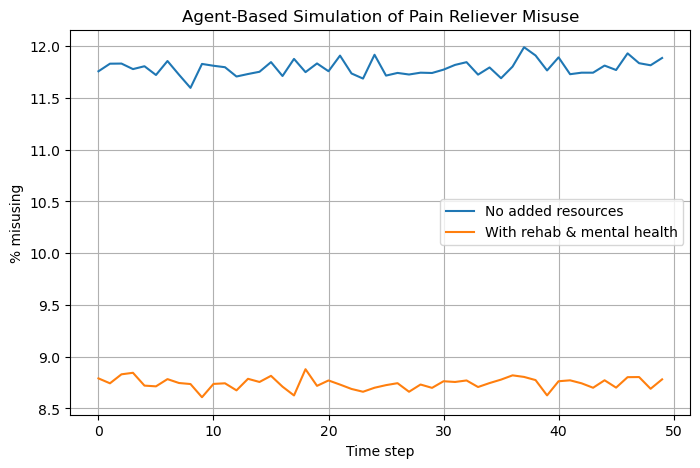

In [26]:
# Comparing with and without mental health resources

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 5))
plt.plot(range(T), np.array(misuse_baseline) * 100, label="No added resources")
plt.plot(range(T), np.array(misuse_resources) * 100, label="With rehab & mental health")
plt.xlabel("Time step")
plt.ylabel("% misusing")
plt.title("Agent-Based Simulation of Pain Reliever Misuse")
plt.legend()
plt.grid(True)
plt.show()

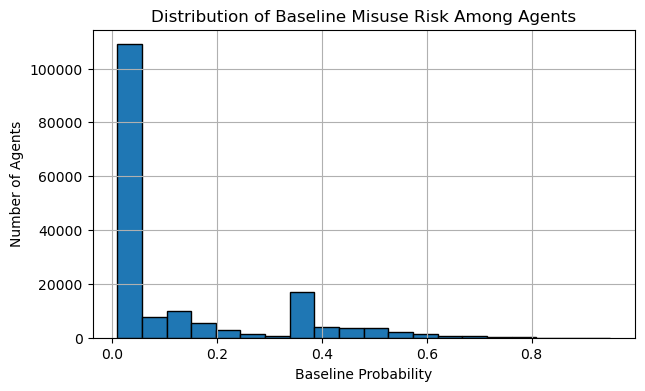

In [36]:
# Visualization on how risky the simulated population is

import matplotlib.pyplot as plt

p_values = [a.p_base for a in agents]

plt.figure(figsize=(7,4))
plt.hist(p_values, bins=20, edgecolor='black')
plt.title("Distribution of Baseline Misuse Risk Among Agents")
plt.xlabel("Baseline Probability")
plt.ylabel("Number of Agents")
plt.grid(True)
plt.show()

COMMUNITY COMPARISON
Average misuse rate (No Resources):     11.79%
Average misuse rate (With Resources):   8.74%
Difference (Improvement):               3.05% fewer misusing

Final misuse rate (No Resources):       11.89%
Final misuse rate (With Resources):     8.78%
Final Difference (End of Simulation):   3.11% fewer misusing


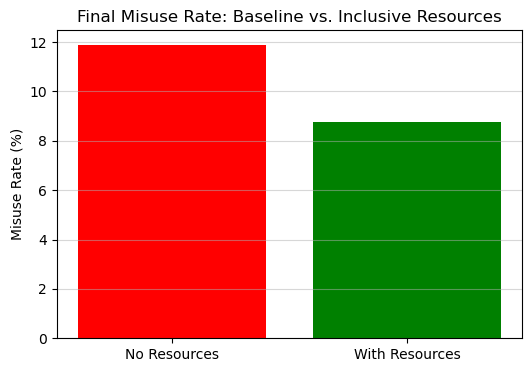

In [44]:
# Visualization comparing the two simulated communities: with and without resources

import numpy as np
import matplotlib.pyplot as plt

baseline = np.array(misuse_baseline)
resource = np.array(misuse_resources)

# average misuse across time
avg_baseline = baseline.mean() * 100
avg_resource = resource.mean() * 100

# final misuse: baseline[-1] means the last misuse rate recorded in the simulation, so we see whether the resource community improves over time.
final_baseline = baseline[-1] * 100
final_resource = resource[-1] * 100



print("COMMUNITY COMPARISON")
print(f"Average misuse rate (No Resources):     {avg_baseline:.2f}%")
print(f"Average misuse rate (With Resources):   {avg_resource:.2f}%")
print(f"Difference (Improvement):               {avg_baseline - avg_resource:.2f}% fewer misusing\n")

print(f"Final misuse rate (No Resources):       {final_baseline:.2f}%")
print(f"Final misuse rate (With Resources):     {final_resource:.2f}%")
print(f"Final Difference (End of Simulation):   {final_baseline - final_resource:.2f}% fewer misusing")


plt.figure(figsize=(6,4))
plt.bar(["No Resources", "With Resources"],
        [final_baseline, final_resource],
        color=["red", "green"])
plt.ylabel("Misuse Rate (%)")
plt.title("Final Misuse Rate: Baseline vs. Inclusive Resources")
plt.grid(axis='y', alpha=0.5)
plt.show()


SUMMARY TABLE
              Misuse Rate  Users Count
HEROINEVR        4.092339         3433
HEROINUSE        3.206965         5346
TRQLZRS         10.000000        38149
SEDATVS          2.642458         8738
COCAINE          1.415630        30565
AMPHETMN         1.351627        26199
HALUCNG          1.255655        55855
EDA_ANY_DRUG     1.404186        47248


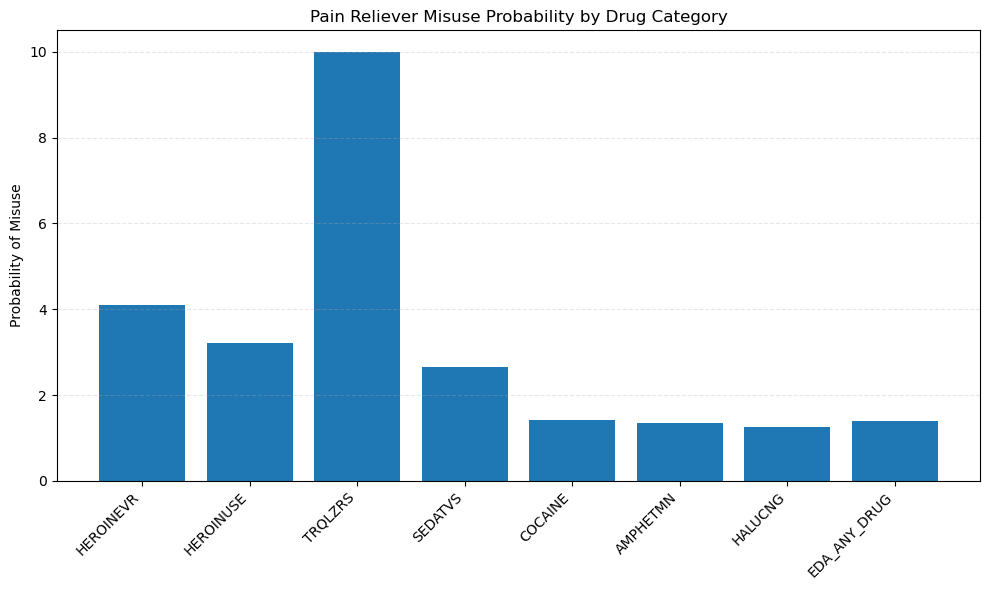

In [50]:
## EXPLORATORY DATA ANALYSIS to look at drug misuse in the dataset. SEPARATE FROM THE SIMULATION

eda_df = pd.read_csv("PDA.csv")

EDA_MISUSE = "PRLMISAB"     
EDA_AGE    = "AGECAT"
EDA_SEX    = "SEX"
EDA_MH     = "MENTHLTH"


EDA_DRUG_LIST = [
    "HEROINEVR",
    "HEROINUSE",
    "TRQLZRS",
    "SEDATVS",
    "COCAINE",
    "AMPHETMN",
    "HALUCNG"
]


eda_subset = eda_df[[EDA_MISUSE, EDA_AGE, EDA_SEX, EDA_MH] + EDA_DRUG_LIST].copy()
eda_subset = eda_subset.dropna()  


for drug in EDA_DRUG_LIST:
    eda_subset[drug] = eda_subset[drug].astype(int)


eda_subset["EDA_ANY_DRUG"] = eda_subset[EDA_DRUG_LIST].sum(axis=1).clip(upper=1)


eda_misuse_rates = {
    drug: eda_subset.loc[eda_subset[drug] == 1, EDA_MISUSE].mean()
    for drug in EDA_DRUG_LIST
}


eda_misuse_rates["EDA_ANY_DRUG"] = eda_subset.loc[
    eda_subset["EDA_ANY_DRUG"] == 1, EDA_MISUSE
].mean()


eda_summary = pd.DataFrame({
    "Misuse Rate": eda_misuse_rates,
    "Users Count": {drug: eda_subset[drug].sum() for drug in eda_misuse_rates}
})

print("\nSUMMARY TABLE")
print(eda_summary)


plt.figure(figsize=(10,6))
plt.bar(eda_summary.index, eda_summary["Misuse Rate"])
plt.title("Pain Reliever Misuse Probability by Drug Category")
plt.ylabel("Probability of Misuse")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()